# This notebook is to evaluate different networks

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
from src.eda.eda_functions import *
from src.eda.subset_network import get_subnetwork, add_missing_genes
from src.eda.process_phenotype import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

<font size=7> Part 1: Network EDA + subselection </font>

In [2]:
%%time
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/TOM_HDID_HS_naive.csv', index_col = 0)

Wall time: 59.8 s


<font size=5> Obtain wgcna module info </font>

In [3]:
# wgcna module info is readily available in this df
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/HDID_top_tables_from_mol_neurobio_paper.csv', skiprows=1)
wgcna_modules = de_data[['Illumina_Probe_Id', 'Module']]
wgcna_modules = wgcna_modules.rename(columns = {'Illumina_Probe_Id':'id', 'Module':'louvain_label'}) # rename to be consistent with the previous analysis

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
wgcna_modules['louvain_label'] = le.fit_transform(wgcna_modules['louvain_label'])

In [35]:
wgcna_modules.to_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/wgcna_modules.csv', index = 0)

# Evaluation 1: Evaluate the whole network with different communities by changing community detection parameters

### Docker Module Extraction

In [26]:
%%time
comm_df1 = run_louvain(tom_df, 1, -1) # default setting
comm_df2 = run_louvain(tom_df, 1, 1)

Wall time: 1min 18s


In [30]:
comm_df1.to_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/network_louvain_default.csv', index = 0)
# Based on the result from cluster_DE_perc(), I decided that comm_df2 provides better module assignment than comm_df1 so comm_df2 is used in the later functions as you'll see
comm_df2.to_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/network_louvain2.csv', index = 0) 

In [7]:
# comm_df1 = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/network_louvain_default.csv')
# comm_df2 = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/network_louvain2.csv')

## Evaluation 1.1: how do # genes change in each community when community assingment changes?

### Docker Module membership analysis

Removing existing folder: output
Created folder output


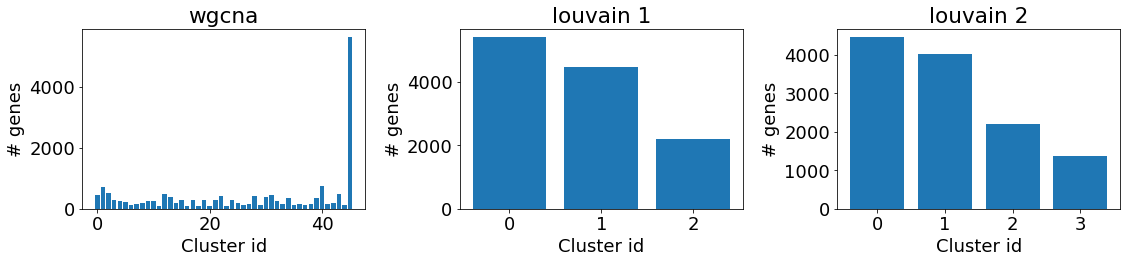

In [8]:
comm_dfs = [wgcna_modules,comm_df1, comm_df2]
comm_names = ['wgcna','louvain 1', 'louvain 2']
plot_gene_cnt_each_cluster(comm_dfs, 'louvain_label', comm_names)

## Evaluation 1.2: how does network cluster stability change when community assingment changes?

In [ ]:
# Skipped because this requires expression_meta_df (not available in this set of data)
# %%time
# cluster_pair_wgcna_n_com1, network_cluster_stability1 = network_cluster_stability(wgcna_modules, comm_df1, 'louvain_label')

### The histogram shows distribution for z scores for p value or correlation coefficient if the cluster membership is randomly assigned. The red vertical line is where the actual Z score is. For p value, the red line should be as left as possible for small p values for the actual cluster. For correlation coefficient, the red line should be either very left or very right to be very negatively correlated or very positively correlated for the actual cluster.

### Docker Module membership analysis

In [ ]:
# skipped
# %%time
# for cluster in comm_df1.louvain_label.unique():
#     plot_random_vs_actual_z(wgcna_modules, comm_df1, cluster_pair_wgcna_n_com1[cluster], cluster, 'louvain_label', network_cluster_stability1, 'wgcna vs louvain 1')

## Evaluation 1.3: how do % DE in each community change when community assingment changes?

### Docker Module DE/ Diagnostic Correlation

In [9]:
# de_data is the equivalence of deseq in the human data
# make adjustment in the column names to be consistent
de_data = de_data[['Illumina_Probe_Id', 'Symbol', 'PFC FC', 'PFC q Value']]
de_data = de_data.rename(columns = {'Illumina_Probe_Id':'id', 'Symbol':'gene', 'PFC FC':'log2FoldChange', 'PFC q Value':'padj'})
de_data['abs_log2FC'] = abs(de_data['log2FoldChange'])

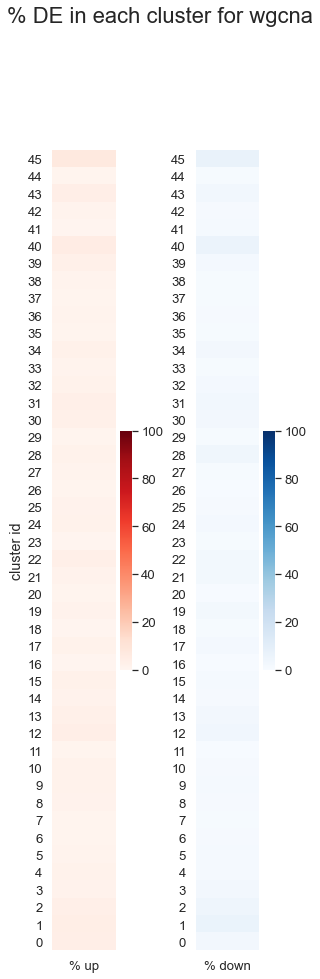

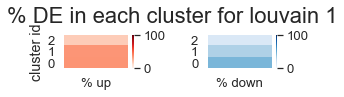

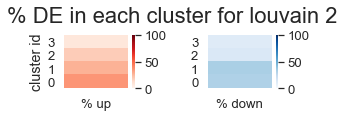

In [10]:
for i, cluster_df in enumerate(comm_dfs):
    cluster_DE_perc(cluster_df, 'louvain_label', comm_names[i], de_data)

## Evaluation 1.4: how do % of significant genes change when community assingment changes (This process takes >10 min to run)

### Docker Module DE/ Diagnostic Correlation

In [ ]:
# skipped
# %%time
# cluster_df_names = ['wgcna','louvain 1', 'louvain 2']
# for i, cluster_df in enumerate([wgcna_modules,comm_df1, comm_df2]):
#     plot_sig_perc(cluster_df, 'louvain_label', cluster_df_names[i])

## Evaluation 1.5: how do trait and community correlation change when community assignment change

### Docker Module DE/ Diagnostic Correlation

In [ ]:
# skipped
# %%time
# cluster_df_names = ['wgcna','louvain 1', 'louvain 2']
# for i, cluster_df in enumerate([wgcna_modules,comm_df1, comm_df2]):
#     cluster_phenotype_corr(cluster_df, 'louvain_label', cluster_df_names[i])

# Evaluation 2: Evaluate subnetwork quality by comparing to the whole network

## Evaluation 2.1: does the scale-free network assumption still hold in the subnetwork?

### Docker Module Subselection

Number of edges: 80483
Figure deg_mod=[0, 1],non_deg_mod=[3],num_genes=100,min_weight=0.069 has been saved.


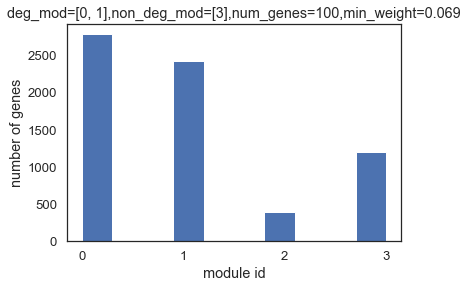

Wall time: 50.3 s


In [11]:
%%time
# New subselection method. This is the biggest change compared to the other notebook. The EDA methods are the same. Only the subselection method is changed. 
subnetwork_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/subnetworks_Jan_25/'
G01_n_3, module01_n_3_df, subnetwork_name1 = get_subnetwork([0,1], 100, 0.069, tom_df, comm_df = comm_df2, deseq = de_data, non_deg_modules = [3], 
                                                            plot_hist = True, hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)

Number of edges: 77692
Figure deg_mod=[0, 1, 2],non_deg_mod=[3],num_genes=100,min_weight=0.068 has been saved.


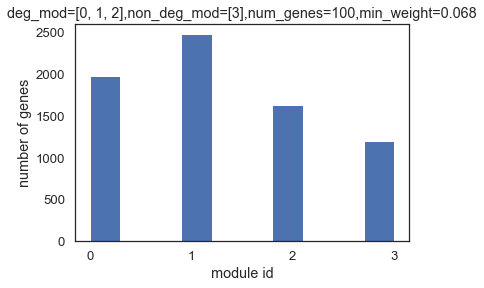

In [12]:
G012_n_3, module012_n_3_df, subnetwork_name2 = get_subnetwork([0,1,2], 100, 0.068, tom_df, comm_df = comm_df2, deseq = de_data, non_deg_modules = [3], 
                                                              plot_hist = True, hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)

Number of edges: 78606
Figure deg_mod=[0, 1],non_deg_mod=[2, 3],num_genes=100,min_weight=0.077 has been saved.


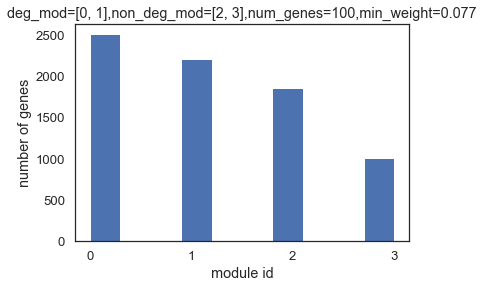

In [13]:
G01_n_23, module01_n_23_df, subnetwork_name3 = get_subnetwork([0,1], 100, 0.077, tom_df, comm_df = comm_df2, deseq = de_data, non_deg_modules = [2,3], 
                                                              plot_hist = True, hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)

In [14]:
subnetwork_dfs = [module01_n_3_df, module012_n_3_df, module01_n_23_df]
subnetwork_Gs = [G01_n_3, G012_n_3, G01_n_23]
subnetwork_names = [subnetwork_name1, subnetwork_name2, subnetwork_name3]

### plot: scale-free check

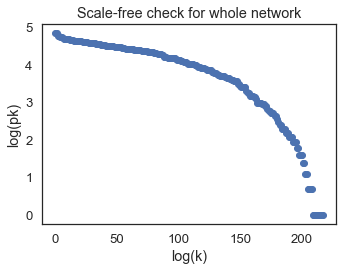

Wall time: 4.58 s


In [15]:
%%time
scale_free_validate(tom_df, 'whole network')

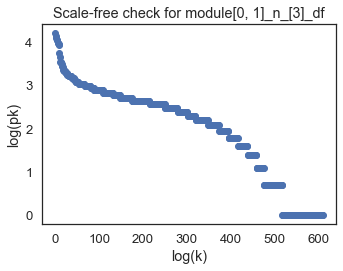

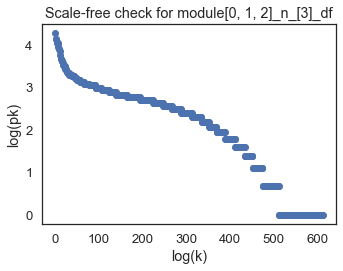

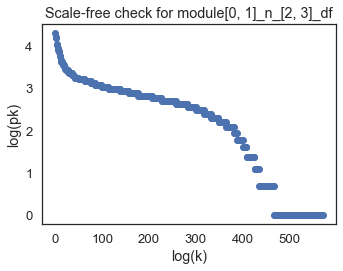

Wall time: 1.58 s


In [16]:
%%time
for i, subnetwork in enumerate(subnetwork_dfs):
    scale_free_validate(subnetwork, subnetwork_names[i])

## Evaluation 2.2: compare network distance by GED and deltacon

### Note to use DeltaCon, the graphs need to have the same number of nodes so use subnetwork without removing the nodes with degree = 0

### Docker Module Subselection

In [17]:
%%time
subnetwork_complete_dfs = []
for subnetwork in subnetwork_dfs:
    subnetwork_complete_dfs.append(add_missing_genes(tom_df, subnetwork))

Wall time: 1min 7s


### plot: graph distance

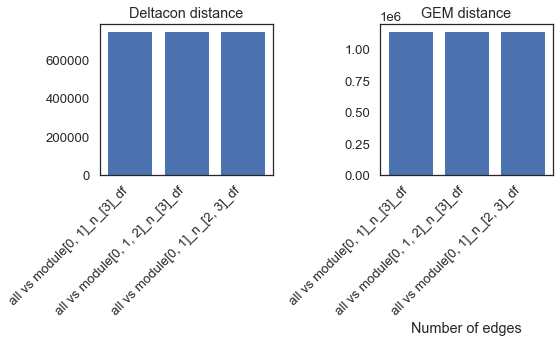

Wall time: 6min 3s


In [20]:
%%time
whole_and_subnetworks = [tom_df] + subnetwork_complete_dfs
plot_graph_distance(whole_and_subnetworks, ['all'] + subnetwork_names)

# Evaluation 3: compare subnetworks by their communities

### Docker Module Subselection

## Evaluation 3.1: compare subnetwork similarities

### Evaluation 3.1a: comparison by jaccard

In [21]:
%%time
# run louvain on subnetworks
subset_communities = []
for subset in subnetwork_dfs:
    subset_communities.append(run_louvain(subset, resolution = 0, n_aggregations = 0))

Wall time: 1.1 s


### Evaluation 3.1a: comparison by jaccard (nodes with degree = 0 excluded)

### plot: jaccard

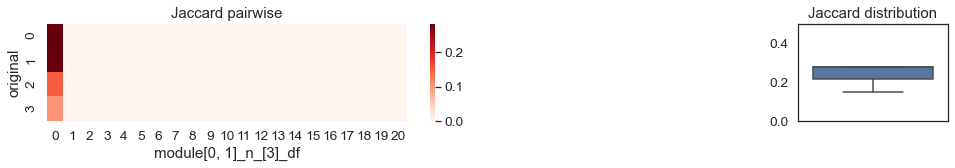

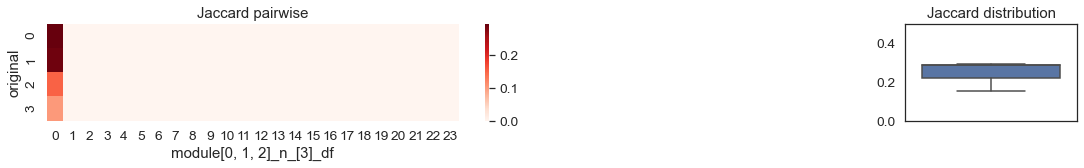

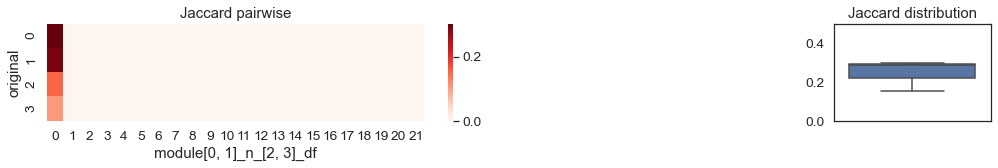

Wall time: 2.51 s


In [23]:
%%time
for i, subset_com in enumerate(subset_communities):
    cluster_jaccard(comm_df2, subset_com, 'louvain_label', ['original', subnetwork_names[i]], cutout_nodes = True, top=3, y_max = 0.5)

### Evaluation 3.1c: comparison of subnetwork by normalized mutual information

### Docker Module Subselection

### plot: NMI

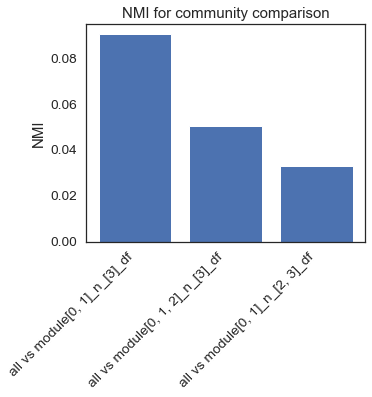

Wall time: 258 ms


In [24]:
%%time
comparison_names = ['all vs ' + name for name in subnetwork_names]
plot_cluster_nmi_comparison('all', comm_df2, subset_communities, 
                            'louvain_label', comparison_names)

## Evaluation 3.2: how do the subnetwork communities compare to the whole network in terms of correlation with the alcohol phenotypes?

### Evaluation 3.2a: compare whole network and subnetwork communities by % DE in each community

### Docker Module Subselection

### plot: DE attributed embedding

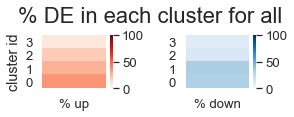

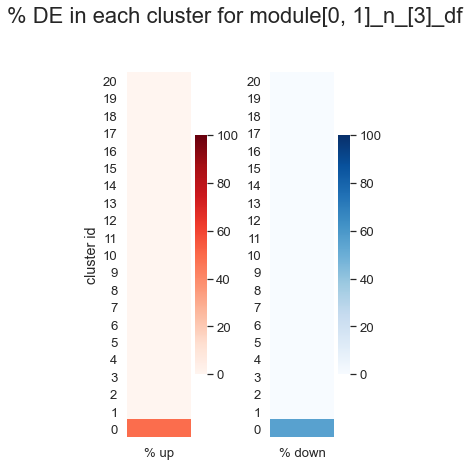

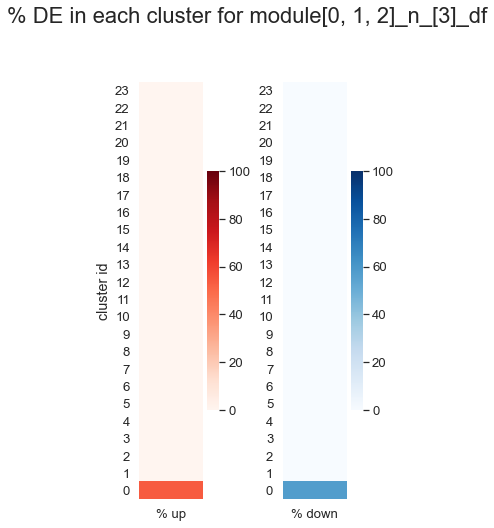

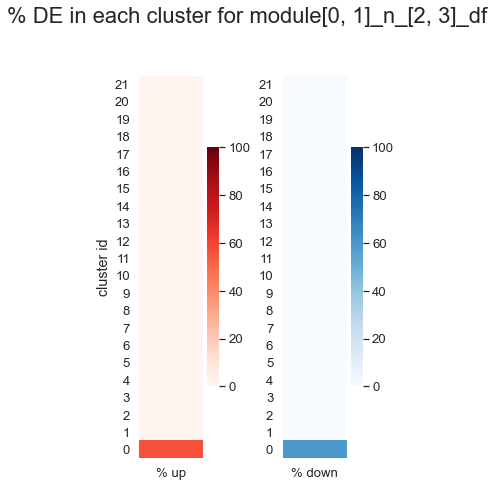

Wall time: 2.84 s


In [27]:
%%time
all_network_names = ['all'] + subnetwork_names
all_communities = [comm_df2] + subset_communities
for i, cluster_df in enumerate(all_communities):
    cluster_DE_perc(cluster_df, 'louvain_label', all_network_names[i], deseq = de_data)

### Evaluation 3.2b: compare whole network and subnetwork communities by % significant genes in each cluster

### Docker Module Subselection

### plot: Num Significant genes

In [ ]:
# skipped
# %%time
# for i, cluster_df in enumerate(all_communities):
#     plot_sig_perc(cluster_df, 'louvain_label', all_network_names[i], expression_meta_df)

### Evaluation 3.2c: compare whole network and subnetwork communities by cluster and trait correlation

### Docker Module Subselection

### Plot: Cluster-Diagnostics corr

In [ ]:
# skipped
# %%time
# for i, cluster_df in enumerate(all_communities):
#     cluster_phenotype_corr(cluster_df, 'louvain_label', all_network_names[i], expression_meta_df)

<font size=7> Part 2: Network embedding </font>

In [28]:
from src.embedding.network_embedding import network_embedding

<font size=5>This took about 1 hour to run

In [31]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Jan25/'
emb_list = []
kmeans_list = []
for i, G in enumerate(subnetwork_Gs):
    emb_df = network_embedding(G, 16, 100, 10, embedding_path, subnetwork_names[i])
    emb_list.append(emb_df)
    kmeans_list.append(run_kmeans(emb_df, 4)) # I chose k = 4 because the original module # was 4 in comm_df2

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [12:16<00:00,  7.36s/it]


embedding data saved


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [12:23<00:00,  7.44s/it]


embedding data saved


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [13:44<00:00,  8.25s/it]


embedding data saved
Wall time: 52min 24s


## Evaluation 1.1: How much is the overlap between the embedding clusters from different subnetworks

### Evalutaion 1.1a: Jaccard to compare cluster similarity

In [32]:
subnetwork_names

['module[0, 1]_n_[3]_df',
 'module[0, 1, 2]_n_[3]_df',
 'module[0, 1]_n_[2, 3]_df']

In [3]:
## The codes here are only when I re-open a session and don't want to redo embeddding, I could just import the embedding df but for containerization, this step is not needed.

# subnetwork_names = []
# for deg, non_deg in zip([[0, 1], [0, 1, 2], [0, 1]], [[3], [3], [2, 3]]):
#     network_name = f'module{deg}_n_{non_deg}_df'
#     subnetwork_names.append(network_name)
# embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Jan25/'
# emb_list = []
# kmeans_list = []
# i = 0
# for file in os.listdir(embedding_path):
#     emb = pd.read_csv(embedding_path + file, index_col = 0)
#     emb_list.append(emb)
#     kmeans_list.append(run_kmeans(emb, 4))
#     i += 1

<font size=6>I chose to compare between the first embedding with the 2nd, 3rd and so on but this should be the user's choice. There's no rule on which one should be compared to which one.

### Plot: jaccard

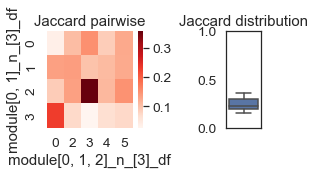

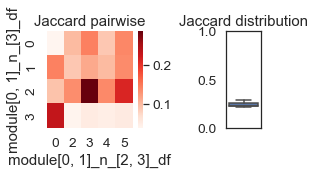

In [34]:
for i in range(1, 3):
    cluster_jaccard(kmeans_list[0], kmeans_list[i], 'kmean_label', [subnetwork_names[0], subnetwork_names[i]], top = 3)

### Evalutaion 1.1b: NMI to compare cluster similarity

<font size=6>This is another place that the user can decide which embedding they want to compare. I used the following for loop to find the embedding with the most nodes and compare everything else against that one. 

In [38]:
for i in range(3):
    print(len(kmeans_list[i]))

6795
7285
7579


### Plot: NMI

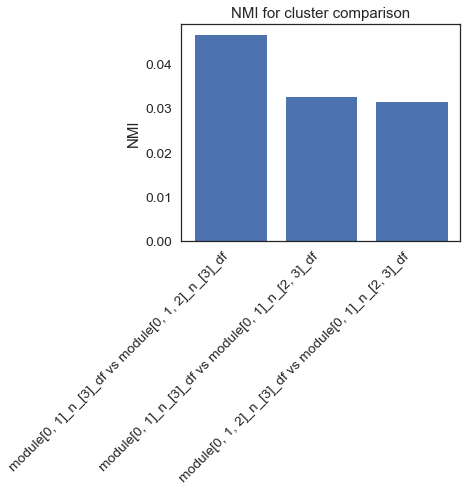

In [74]:
# plot_cluster_nmi_comparison_v2() is new. It's easier for user to customize. I found it to be more useful than plot_cluster_nmi_comparison()
plot_cluster_nmi_comparison_v2([kmeans_list[0], kmeans_list[0], kmeans_list[1]], [kmeans_list[1], kmeans_list[2], kmeans_list[2]], 
                               [subnetwork_names[0], subnetwork_names[0], subnetwork_names[1]], 
                               [subnetwork_names[1], subnetwork_names[2], subnetwork_names[2]], 'kmean_label')

## Evaluation 1.2: How much do cluster and phenotype correlation change when subnetworks (vs whole network) were used for embedding?

### Evaluation 1.2a: compare whole network and subnetwork embedding by % DE in each cluster

### Plot: DE Attributed embedding

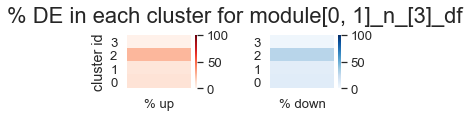

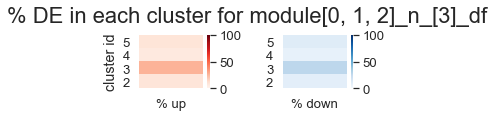

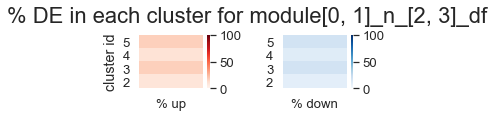

In [76]:
# Note that this is just an example of comparing different subnetwork embedding, not necessarily a great subnetwork example
for i, kmeans in enumerate(kmeans_list):
    cluster_DE_perc(kmeans, 'kmean_label', subnetwork_names[i], deseq = de_data)

### Evaluation 1.2b: Measure percentage of genes in each cluster that are significantly variable for specific traits

### Plot: Cluster-Num Significant genes

In [ ]:
# skipped
# %%time
# for i, kmeans in enumerate(kmeans_list):
#     plot_sig_perc(kmeans, 'kmean_label', subnetwork_names[i], expression_meta_df)

### Evaluation 1.2c: Measure cluster and alcohol phenotype correlation

### Plot: Cluster-Diagnostics corr

In [ ]:
# skipped
# %%time
# for i, kmeans in enumerate(kmeans_list):
#     cluster_phenotype_corr(kmeans, 'kmean_label', subnetwork_names[i], expression_meta_df)